<a href="https://colab.research.google.com/gitlab/tomasz.wrobel/apache-beam-lab/blob/master/apache-beam-lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

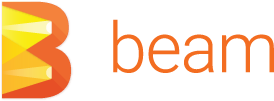

# What is Apache Beam? 


Apache Beam (***B***atch + str**EAM**) is a unified programming model for parallel batch and streaming data processing. Using a single SDK you define and construct data processing pipelines as well as runners and execute them.

Beam is commonly used for Extract-Transform-Load (ETL) jobs, where we extract data from a data source, transform that data, and load it into a data sink like a database. It does particularly well with large amounts of data since it can use mutliple machines to process everything at the same time.


### SDKs
The Beam SDK's programming model can represent and transform bounded and unbounded datasets of any size, meaning that it can handle a finite data set from a batch data source or an infinite data set from a streaming data source. The SDK uses the same interfaces to deal with these data sources in a unified manner.

Currently Beam supports Java, Python and Go.

### Pipeline runners
The Beam Pipeline Runners translate the data processing pipeline you define with your Beam program into an API compatible with the distributed processing back-end of your choice. At this point you specify an appropriate runner for the back-end, which determined where your pipeline will execute.

Beam supports the following popular runners and more:
* Apache Flink
* Apache Spark
* Google Cloud Dataflow

Additionally, there is an option to run your pipeline with Beam's `DirectRunner` which provides a locally embedded runner.

### Why use it?
Beam’s intention isn’t to replace Apache Spark. Instead, Beam promises to unify all data processing engines in a single model and syntax. The idea is to write a pipeline using one of the SDKs that Beam provides and execute it on one of the supported engines. In additions it provides:

* Seamless interaction with batch and streaming data sets
* Runtime portability
* Layer of abstraction that captures properties of your data and your logic





# Apache Beam Lab

Let's begin by installing the `apache-beam` package with `pip`.

In [1]:
# Install apache-beam with pip.
!pip install --quiet apache-beam pandas

In [15]:
# Run and print a shell command.
def run(cmd):
    print('>> {}'.format(cmd))
    !{cmd}
    print('')

import requests
def get_words_from_file():
    url = 'https://raw.githubusercontent.com/twrobel/apache-beam-lab/main/data.txt'
    r = requests.get(url, allow_redirects=True)
    return r.text.split()

You can express a _data processing pipeline_, and then run it on the
[_runner_ of your choice](https://beam.apache.org/documentation/runners/capability-matrix/).
For now, we use the `DirectRunner` which runs locally for simplicity.

# What is a _pipeline_?

A __pipeline__ is a __sequence of data transformations__.
You can think of it like a production line,
data comes in from one end,
it gets transformed by each step.
The outputs from one step are passed as inputs to the next step.

In Beam, your data lives in a __`PCollection`__,
which stands for _Parallel Collection_.
A `PCollection` is like a __list of elements__,
but without any order guarantees.
This allows Beam to easily parallelize and distribute
the `PCollection`'s elements.

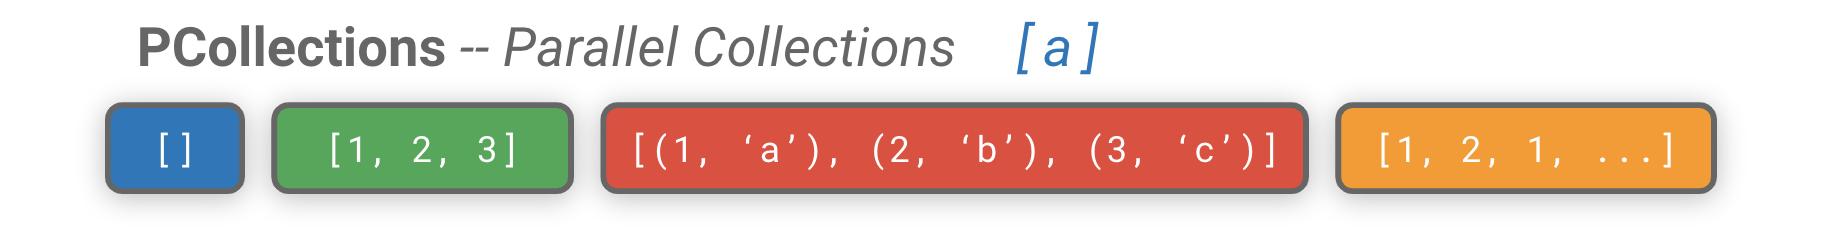

Once you have your data, the next step is to transform it.
In Beam, you transform data using **`PTransform`**s,
which stands for _Parallel Transform_.
A `PTransform` is like a __function__,
they take some inputs, transform them and create some outputs.

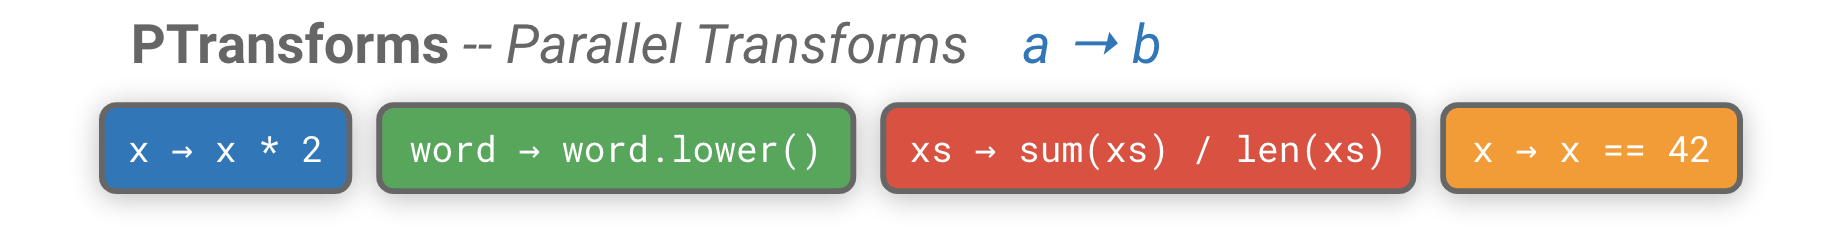

Now let's dive into creating our first pipeline.
 
For this first pipeline, let's just feed it some data from a Python list and print the results.

Each _step_ in the pipeline is delimited by the _pipe operator_ `|`.
The outputs of each transform are passed to the next transform as inputs.
And we can save the final results into a `PCollection` variable.

```py
# We pass the elements from step1 through step3 and save the results into `outputs`.
outputs = pipeline | step1 | step2 | step3
```

Pipelines can quickly grow long, so it's sometimes easier to read if we surround them with parentheses and break them into multiple lines.

```py
# This is equivalent to the example above.
outputs = (
  pipeline
  | step1
  | step2
  | step3
)
```

Also, Beam expects each transform, or step, to have a unique _label_, or description.
This makes it a lot easier to debug, and it's in general a good practice to start.
You can use the _right shift operator_ `>>` to add a label to your transforms, like `'My description' >> MyTransform`.

```py
# Try to give short but descriptive labels.
# These serve both as comments and help debug later on.
outputs = (
  pipeline
  | 'First step' >> step1
  | 'Second step' >> step2
  | 'Third step' >> step3
)
```

> ℹ️&nbsp; The syntax might seem a little different at first, but you'll become familiar with it.

We use the `Create` transform to feed the pipeline with an
[`iterable`](https://docs.python.org/3/glossary.html#term-iterable)
of elements, like a `list`.

Let's try to see what happens if we try to `print` a PCollection.

In [3]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

# Create a pipeline.
with beam.Pipeline() as pipeline:
  # Feed it some input elements with `Create`.
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(inputs)
  )

  # `outputs` is a PCollection with our input elements.
  # But printing it directly won't show us its contents :(
  print(f"outputs: {outputs}")

outputs: PCollection[[3]: Create initial values/Map(decode).None]


# Example 1
Printing elements from a list

In [4]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(inputs)
  )

  # We can only access the elements through another transform.
  outputs | beam.Map(print)

0
1
2
3


# Exercise 1

Print words from a list

In [16]:
import apache_beam as beam

words_list = get_words_from_file()

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print) 

Lorem
Ipsum
is
simply
dummy
text
of
the
printing
and
typesetting
industry.
Lorem
Ipsum
has
been
the
industry's
standard
dummy
text
ever
since
the
1500s,
when
an
unknown
printer
took
a
galley
of
type
and
scrambled
it
to
make
a
type
specimen
book.
It
has
survived
not
only
five
centuries,
but
also
the
leap
into
electronic
typesetting,
remaining
essentially
unchanged.
It
was
popularised
in
the
1960s
with
the
release
of
Letraset
sheets
containing
Lorem
Ipsum
passages,
and
more
recently
with
desktop
publishing
software
like
Aldus
PageMaker
including
versions
of
Lorem
Ipsum.


Expected: <br/>
<br/>
Lorem<br/>
Ipsum<br/>
is<br/>
simply<br/>
dummy<br/>
text<br/>
of<br/>
the<br/>
printing<br/>
...


# Transforming data

Apache Beam is designed with a [functional paradigm](https://en.wikipedia.org/wiki/Functional_programming).
This means that, instead of _loops_, it uses `PTransform`s alongside with _functions_ to process each element in a `PCollection`.

Let's go through some of the most common and basic data transforms in Beam.

## Map: _one-to-one_

Let's say we have some elements and we want to do something with each element.

We want to `map` a function to each element of the collection.

`map` takes a _function_ that transforms a single input `a` into a single output `b`.

> ℹ️ -- For example, we want to multiply each element by 2.

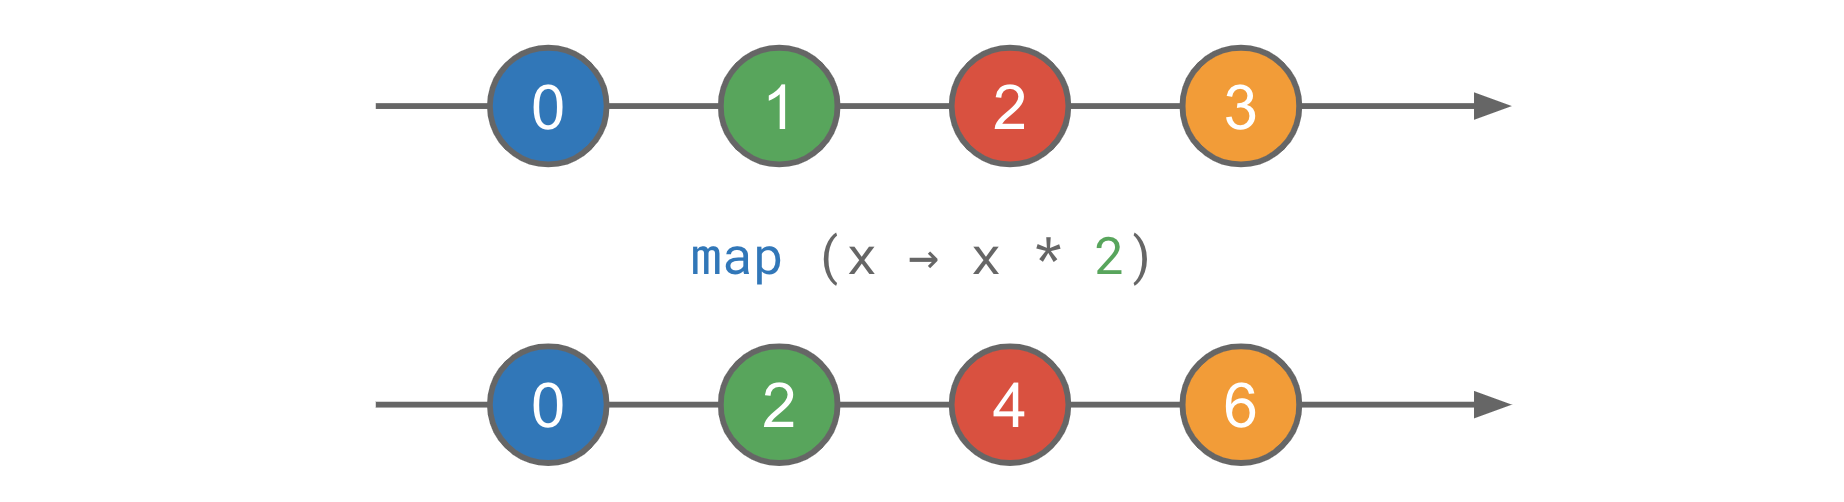

In Beam, there is the
[`Map` transform](https://beam.apache.org/documentation/transforms/python/elementwise/map/),
but we must use it within a pipeline.

First we create a pipeline and feed it our input elements.
Then we _pipe_ those elements into a `Map` transform where we apply our function.

# Example 2

In [7]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Multiply by 2' >> beam.Map(lambda x: x * 2)
  )

  outputs | beam.Map(print)

0
2
4
6


# Exercise 2

Print words uppercased

In [18]:
import apache_beam as beam

words_list = get_words_from_file()

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)


LOREM
IPSUM
IS
SIMPLY
DUMMY
TEXT
OF
THE
PRINTING
AND
TYPESETTING
INDUSTRY.
LOREM
IPSUM
HAS
BEEN
THE
INDUSTRY'S
STANDARD
DUMMY
TEXT
EVER
SINCE
THE
1500S,
WHEN
AN
UNKNOWN
PRINTER
TOOK
A
GALLEY
OF
TYPE
AND
SCRAMBLED
IT
TO
MAKE
A
TYPE
SPECIMEN
BOOK.
IT
HAS
SURVIVED
NOT
ONLY
FIVE
CENTURIES,
BUT
ALSO
THE
LEAP
INTO
ELECTRONIC
TYPESETTING,
REMAINING
ESSENTIALLY
UNCHANGED.
IT
WAS
POPULARISED
IN
THE
1960S
WITH
THE
RELEASE
OF
LETRASET
SHEETS
CONTAINING
LOREM
IPSUM
PASSAGES,
AND
MORE
RECENTLY
WITH
DESKTOP
PUBLISHING
SOFTWARE
LIKE
ALDUS
PAGEMAKER
INCLUDING
VERSIONS
OF
LOREM
IPSUM.


Expected:<br/>
<br/>
LOREM<br/>
IPSUM<br/>
IS<br/>
SIMPLY<br/>
DUMMY<br/>
TEXT<br/>
OF<br/>
THE<br/>
PRINTING<br/>
...

## FlatMap: _one-to-many_

`Map` allows us to transform each individual element,
but we can't change the number of elements with it.

We want to `map` a function to each element of a collection.
That function returns a _list of output elements_,
so we would get a _list of lists of elements_.
Then we want to _flatten_ the _list of lists_ into a single _list_.

`flatMap` takes a function that transforms a single input `a` into an `iterable` of outputs `b`.
But we get a _single collection_ containing the outputs of _all_ the elements.

> ℹ️ -- For example, we want to have as many elements as the element's value.
> For a value `1` we want one element, and three elements for a value `3`.

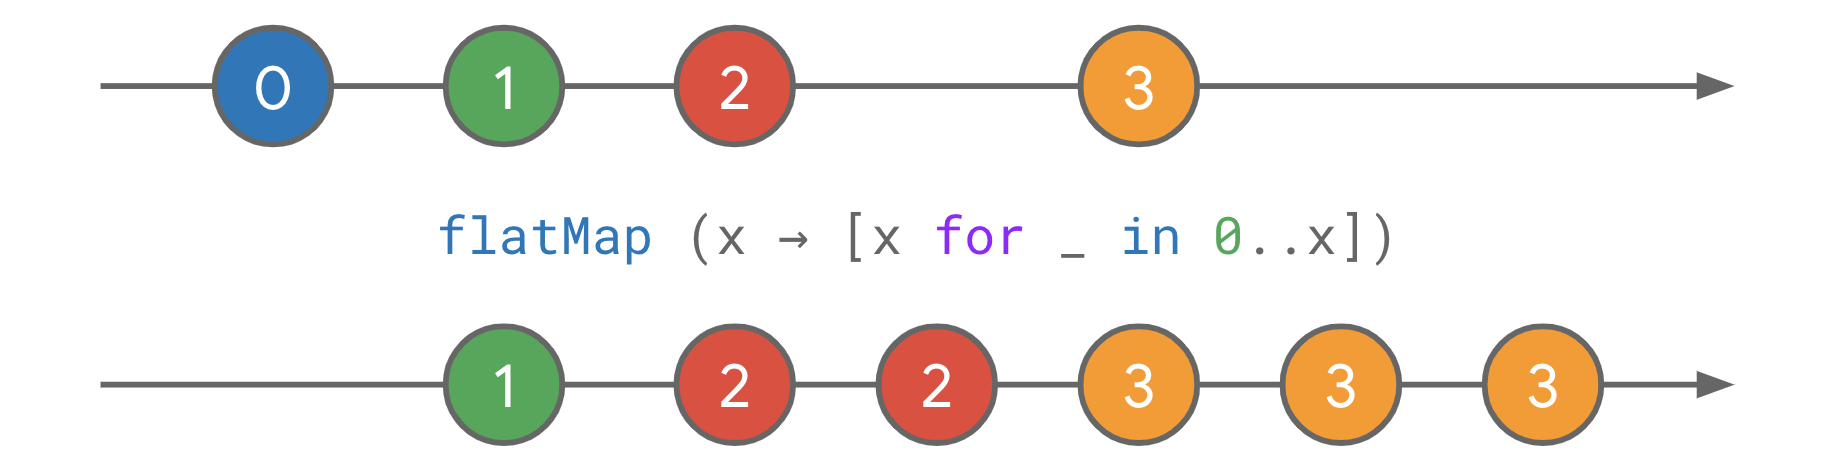

The good news is that Beam already has a
[`FlatMap` transform](https://beam.apache.org/documentation/transforms/python/elementwise/flatmap/)
built-in, so it's actually easier than plain Python.

`FlatMap` accepts a function that takes a single input element and outputs an `iterable` of elements.

# Example 3

In [10]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Expand elements' >> beam.FlatMap(lambda x: [x for _ in range(x)])
  )

  outputs | beam.Map(print)

1
2
2
3
3
3


> ℹ️ Try replacing the `FlatMap` transform with `Map` to see how they behave differently.

# Exercise 3
Duplicate each word that starts with capital letter.

In [22]:
import apache_beam as beam

def starts_with_uppercase(word):
    return word[0].isupper()

words_list = get_words_from_file()

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)


Lorem
Lorem
Ipsum
Ipsum
is
simply
dummy
text
of
the
printing
and
typesetting
industry.
Lorem
Lorem
Ipsum
Ipsum
has
been
the
industry's
standard
dummy
text
ever
since
the
1500s,
when
an
unknown
printer
took
a
galley
of
type
and
scrambled
it
to
make
a
type
specimen
book.
It
It
has
survived
not
only
five
centuries,
but
also
the
leap
into
electronic
typesetting,
remaining
essentially
unchanged.
It
It
was
popularised
in
the
1960s
with
the
release
of
Letraset
Letraset
sheets
containing
Lorem
Lorem
Ipsum
Ipsum
passages,
and
more
recently
with
desktop
publishing
software
like
Aldus
Aldus
PageMaker
PageMaker
including
versions
of
Lorem
Lorem
Ipsum.
Ipsum.


Expected:<br/>
<br/>
Lorem<br/>
Lorem<br/>
Ipsum<br/>
Ipsum<br/>
is<br/>
simply<br/>
dummy<br/>
text<br/>
...

## Filter: _one-to-zero_

Sometimes we want to *only* process certain elements while ignoring others.

We want to `filter` each element in a collection using a function.

`filter` takes a function that checks a single element `a`,
and returns `True` to keep the element, or `False` to discard it.

> ℹ️ -- For example, we only want to keep number that are *even*, or divisible by two.
> We can use the
> [modulo operator `%`](https://en.wikipedia.org/wiki/Modulo_operation)
> for a simple check.

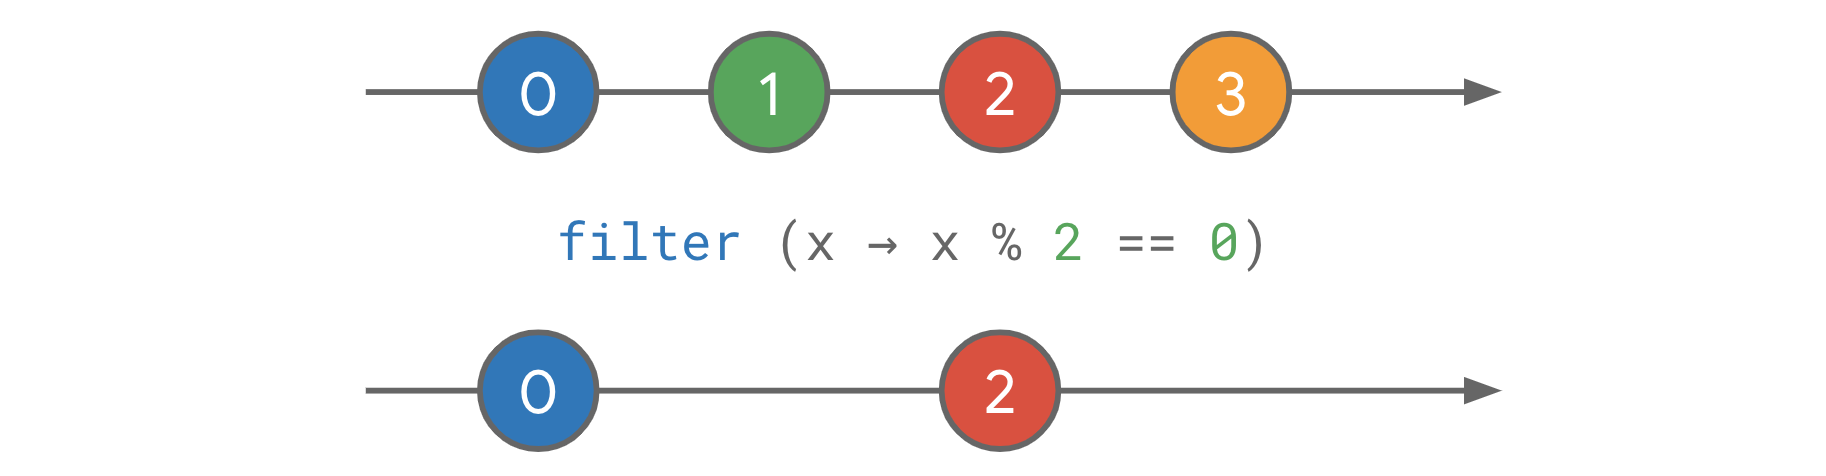

In Beam, there is the
[`Filter` transform](https://beam.apache.org/documentation/transforms/python/elementwise/filter/).

# Example 4

In [13]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Keep only even numbers' >> beam.Filter(lambda x: x % 2 == 0)
  )

  outputs | beam.Map(print)

0
2


# Exercise 4
From a list of words print out only words that do not start with a vowel 

In [25]:
import apache_beam as beam

def starts_with_vowel(word):
    return 'aoieu'.find(word[0])!=-1

words_list = get_words_from_file()

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create initial values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)


Lorem
Ipsum
simply
dummy
text
the
printing
typesetting
Lorem
Ipsum
has
been
the
standard
dummy
text
since
the
1500s,
when
printer
took
galley
type
scrambled
to
make
type
specimen
book.
It
has
survived
not
five
centuries,
but
the
leap
typesetting,
remaining
It
was
popularised
the
1960s
with
the
release
Letraset
sheets
containing
Lorem
Ipsum
passages,
more
recently
with
desktop
publishing
software
like
Aldus
PageMaker
versions
Lorem
Ipsum.


Expected:<br/>
<br/>
Lorem<br/>
Ipsum<br/>
simply<br/>
dummy<br/>
text<br/>
the<br/>
printing<br/>
typesetting<br/>
Lorem<br/>
...

## Combine: _many-to-one_

We also need a way to get a single value from an entire `PCollection`.
We might want to get the total number of elements, or the average value, or any other type of _aggregation_ of values.

We want to `combine` the elements in a collection into a single output.

`combine` takes a function that transforms an `iterable` of inputs `a`, and returns a single output `a`.

Other common names for this function are `fold` and `reduce`.

> ℹ️ -- For example, we want to add all numbers together.

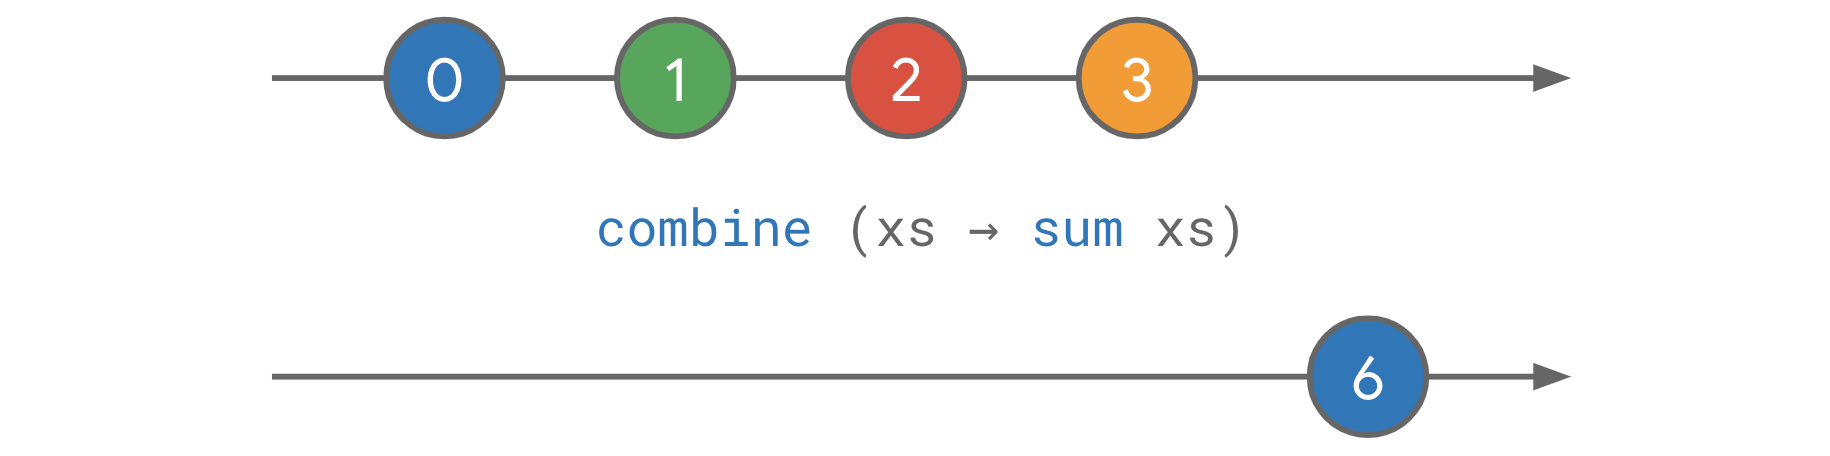

In Beam, there are
[aggregation transforms](https://beam.apache.org/documentation/transforms/python/overview/#aggregation).

For this particular example, we can use the
[`CombineGlobally` transform](https://beam.apache.org/documentation/transforms/python/aggregation/sum/)
which accepts a function that takes an iterable of elements as an input and outputs a single value.

We can pass the
[built-in function `sum`](https://docs.python.org/3/library/functions.html#sum)
into `CombineGlobally`.

# Example 5

In [16]:
import apache_beam as beam

inputs = [0, 1, 2, 3]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(inputs)
      | 'Sum all values together' >> beam.CombineGlobally(sum)
  )

  outputs | beam.Map(print)

6


# Exercise 5
Count all the vowels in words from a list

In [28]:
import apache_beam as beam

def number_of_vowels(word):
    return sum(map(word.lower().count, "aeiou"))

words_list = get_words_from_file()


with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)

168


Expected:<br/>
<br/>
168

## GroupByKey: _group related elements_

Sometimes it's useful to pair each element with a *key* that we can use to group related elements together.

Think of it as creating a
[Python `dict`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)
from a list of `(key, value)` pairs,
but instead of replacing the value on a "duplicate" key,
you would get a list of all the values associated with that key.

> ℹ️ -- For example, we want to group each animal with the list of foods they like, and we start with `(animal, food)` pairs.

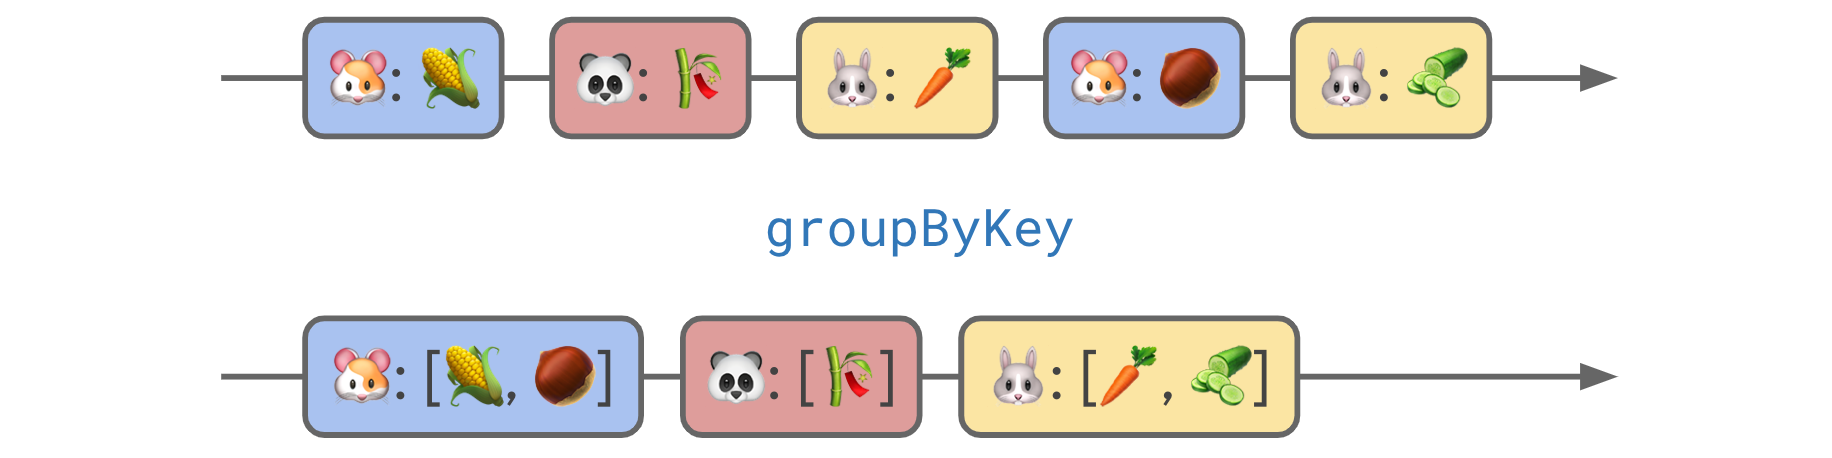

In Beam, there is the
[`GroupByKey` transform](https://beam.apache.org/documentation/transforms/python/aggregation/groupbykey/).

In [19]:
import apache_beam as beam

inputs = [
  ('🐹', '🌽'),
  ('🐼', '🎋'),
  ('🐰', '🥕'),
  ('🐹', '🌰'),
  ('🐰', '🥒'),
]

with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create (animal, food) pairs' >> beam.Create(inputs)
      | 'Group foods by animals' >> beam.GroupByKey()
  )

  outputs | beam.Map(print)

('🐹', ['🌽', '🌰'])
('🐼', ['🎋'])
('🐰', ['🥕', '🥒'])


# Exercise 6
Group words by their first letter ignoring the case

In [30]:
import apache_beam as beam

words_list = get_words_from_file()

# Create Pipeline, use Map to create PCollection of tuples
with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)


('l', ['Lorem', 'Lorem', 'leap', 'Letraset', 'Lorem', 'like', 'Lorem'])
('i', ['Ipsum', 'is', 'industry.', 'Ipsum', "industry's", 'it', 'It', 'into', 'It', 'in', 'Ipsum', 'including', 'Ipsum.'])
('s', ['simply', 'standard', 'since', 'scrambled', 'specimen', 'survived', 'sheets', 'software'])
('d', ['dummy', 'dummy', 'desktop'])
('t', ['text', 'the', 'typesetting', 'the', 'text', 'the', 'took', 'type', 'to', 'type', 'the', 'typesetting,', 'the', 'the'])
('o', ['of', 'of', 'only', 'of', 'of'])
('p', ['printing', 'printer', 'popularised', 'passages,', 'publishing', 'PageMaker'])
('a', ['and', 'an', 'a', 'and', 'a', 'also', 'and', 'Aldus'])
('h', ['has', 'has'])
('b', ['been', 'book.', 'but'])
('e', ['ever', 'electronic', 'essentially'])
('1', ['1500s,', '1960s'])
('w', ['when', 'was', 'with', 'with'])
('u', ['unknown', 'unchanged.'])
('g', ['galley'])
('m', ['make', 'more'])
('n', ['not'])
('f', ['five'])
('c', ['centuries,', 'containing'])
('r', ['remaining', 'release', 'recently'])
('v'

Expected:<br/>
<br/>
('l', \['Lorem', 'Lorem', 'leap', 'Letraset', 'Lorem', 'like', 'Lorem'\])<br/>
('i', \['Ipsum', 'is', 'industry.', 'Ipsum', "industry's", 'it', 'It', 'into', 'It', 'in', 'Ipsum', 'including', 'Ipsum.'\])<br/>
('s', \['simply', 'standard', 'since', 'scrambled', 'specimen', 'survived', 'sheets', 'software'\])<br/>
('d', \['dummy', 'dummy', 'desktop'\])<br/>
...

# Exercise 7
Find the longest word for each starting letter

In [32]:
import apache_beam as beam
from itertools import islice

def select_longest(words: list):
    return max(words, key=len)

words_list = get_words_from_file()


# Create Pipeline, use select_longest above and CombinePerKey transform
with beam.Pipeline() as pipeline:
  outputs = (
      pipeline
      | 'Create values' >> beam.Create(words_list)
      # YOUR CODE GOES HERE
  )

  outputs | beam.Map(print)


('l', 'Letraset')
('i', "industry's")
('s', 'scrambled')
('d', 'desktop')
('t', 'typesetting,')
('o', 'only')
('p', 'popularised')
('a', 'Aldus')
('h', 'has')
('b', 'book.')
('e', 'essentially')
('1', '1500s,')
('w', 'when')
('u', 'unchanged.')
('g', 'galley')
('m', 'make')
('n', 'not')
('f', 'five')
('c', 'centuries,')
('r', 'remaining')
('v', 'versions')


Expected: <br/>
<br/>
('l', 'Letraset')<br/>
('i', "industry's")<br/>
('s', 'scrambled')<br/>
('d', 'desktop')<br/>
('t', 'typesetting,')<br/>
('o', 'only')<br/>
('p', 'popularised')<br/>
('a', 'Aldus')<br/>
...

# Word count example

The following example is the "Hello, World!" of data processing, a basic implementation of word count. We're creating a simple data processing pipeline that reads a text file and counts the number of occurrences of every word.

There are many scenarios where all the data does not fit in memory. Notice that the outputs of the pipeline go to the file system, which allows for large processing jobs in distributed environments.

In [33]:
# Copy the input file into the local file system.
run('mkdir -p data')
run('gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt data/')

>> mkdir -p data

>> gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt data/

Copying gs://dataflow-samples/shakespeare/kinglear.txt...
/ [0 files][    0.0 B/153.6 KiB]                                                
/ [1 files][153.6 KiB/153.6 KiB]                                                

Operation completed over 1 objects/153.6 KiB.                                    


In [59]:
import apache_beam as beam
import re
import shutil

inputs_pattern = 'data/kinglear.txt'
outputs_prefix = 'outputs/part'
shutil.rmtree('outputs',ignore_errors=True)

def split_line_to_words(line):
  return re.findall(r"[a-zA-Z']+", line)

# Running locally in the DirectRunner.
with beam.Pipeline() as pipeline:
  # Store the word counts in a PCollection.
  # Make each element a tuple of (word, count) of types (str, int).
  word_counts = (
      # The input PCollection is an empty pipeline.
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(inputs_pattern)
      # YOUR CODE GOES HERE
     
      # split into individual words
      # pair each word into a tuple with 1
      # group and sum 
     
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

# See outputs/parts file for results

# Solution:

In [48]:
import apache_beam as beam
import re
import shutil

inputs_pattern = 'data/kinglear.txt'
outputs_prefix = 'outputs/part'
shutil.rmtree('outputs',ignore_errors=True)

# Running locally in the DirectRunner.
with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(inputs_pattern)
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

